## Pré-traitements

Import des librairies nécessaires

In [1]:
import pptk
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset
from scipy.interpolate import griddata
from scipy.ndimage import gaussian_filter

Import du DSM

In [2]:
# récupération des altitudes au format d[x,y] = altitude


dataset = Dataset('data.nc')
d = dataset.variables['altitude'][0:225,0:225]
s = d.shape

# Pour utiliser pptk.viewer les data sont mises sous formes points3D = [x,y,altitude]
# les points qui n'ont pas d'altitude ont une valeur abérante (9,36... e36)
# on garde donc seulement les valeurs inférieures à 100 000
# ensuite pour utiliser scipy.griddata on doit séparer les couples coordonnées des altitudes:
# points[i] = [Xi,Yi] et value[i] = ALTITUDEi

pointcloud =[]
points =[]
values =[]
for i in range(0,s[0]):
    for j in range(0,s[1]):
        if d[i,j] < 100000:
            pointcloud.append([i,j,d[i,j]])
            points.append([i,j])
            values.append(d[i,j])

# visualisation du nuage de points avant interpolation des valeurs manquantes -> DSM
v = pptk.viewer(pointcloud)

Interpolation des valeurs manquantes

In [3]:
grid_x, grid_y = np.mgrid[0:s[0]-1:1, 0:s[1]-1:1]
interpolated_grid = griddata(points, values, (grid_x, grid_y), method='cubic')
#plt.imshow(interpolated_grid.T, extent=(0,1,0,1), origin='lower')

s_interpolated = interpolated_grid.shape
interpolated_pointcloud =[]
for i in range(0,s_interpolated[0]):
    for j in range(0,s_interpolated[1]):
            interpolated_pointcloud.append([i,j,interpolated_grid[i,j]])
            
# visualisation du nuage de points après interpolation des valeurs manquantes -> DSM
v2 = pptk.viewer(interpolated_pointcloud)

## MSD

Paramètres

In [4]:
# Seuil de difference de hauteur en mètre
dThrHeightDiff = 3
# Seuil de difference de pente en degrès
dThrSlope = 30
# taille de la fenetre glissante d'analyse
iExt = 91
# sigma pour noyau gaussien
sig = 27

Variables

In [19]:
# direction des lignes de selection, seulement les directions partant d'en haut à gauche vers en bas à droite
scanlines_direction = [[1,0],[1,1],[0,1],[1,-1]]
# stockage des labels
# labels[i,j] = nb_vote_exclusion
# il y a 8 scanlines, donc 8 votants, si oLabel[i,j] > 5 alors le pixel (i,j) est conservé car
# considéré comme un point du sol
oLabel = np.zeros((s_interpolated[0],s_interpolated[1]))
# DSM
oDSM = interpolated_grid
# DSM smooth
oDSMs= gaussian_filter(oDSM,sigma=sig,mode='nearest')
# X = [-(iExt-1)/2:+(iExt-1)/2] utilité ?
X = np.arange((-1*(iExt-1)/2),((iExt-1)/2),1)

Fonction de récupération des voisins d'un pixel selon une direction donnée (iX et iY sont les décalage donnant la direction)

In [ ]:
def getNeigh(oDSM,x,y,iX,iY,iExt):
    values = [oDSM[x,y]]
    nbValues = int((iExt-1)/2)
    for i in range(1,nbValues,1):
        if x+i*iX < s[0]-1 and y+i*iY < s[1]-1 and x+i*iX >= 0 and y+i*iY >= 0:
            values.append(oDSM[x+i*iX,y+i*iY])
        if x-i*iX >= 0 and y-i*iY >= 0 and x-i*iX < s[0]-1 and y-i*iY < s[1]-1:
            values.append(oDSM[x-i*iX,y-i*iY])
    return values

Fonction éxécutant le DSM

In [24]:
def DSM_one_pass(oDSM,oDSMs,scanlines_direction,iExt,oLabel,dThrHeightDiff,dThrSlope):
    s = oDSM.shape
    for [iX,iY] in scanlines_direction:
        for x in range(0,s[0]-1):
            for y in range(0,s[1]-1):
                # local height difference
                oDSMDiff = oDSM[x,y] - oDSM[x+iX,y+iY]
                # local terrain slope
                oDSMsDiff = oDSMs[x,y] - oDSMs[x+iX,y+iY]
                # get neightborhood (our filter extend)
                #oNeigh = oDSM[x+oExtX[iDir],y+oExtY[iDir]]
                oNeigh = getNeigh(oDSM,x,y,iX,iY,iExt)
                # slope corrected height values
                oNeighCorr = oNeigh + oDSMs[x,y]
                # slope corrected minimal terrain value
                oMinNeigh = min(oNeighCorr)
                # difference to minimum
                dHeightDiff = oDSM[x,y] - oMinNeigh
                if dHeightDiff > dThrHeightDiff: 
                    # pixel is non-ground
                    oLabel[x,y] = oLabel[x,y] #on ajoute rien
                else:
                    # slope corrected height difference
                    dDelta = oDSMDiff - oDSMsDiff
                    dSignDelta = -np.sign(dDelta)
                    dSlopeLocal = np.arctan2(np.absolute(dDelta),1)*180/np.pi
                    # slope corrected angle
                    dSlope = dSlopeLocal*dSignDelta
                    if dSlope > dThrSlope :
                        # pixel is non-ground
                        oLabel[x,y] = oLabel[x,y] #on ajoute rien
                    else: 
                        # assign as last label
                        # pas bon car reporte tout les votes en oLabel[x-iX,y-iY]
                        oLabel[x,y] = oLabel[x-iX,y-iY]
                    if dSlope < 0:
                        # pixel is ground
                        oLabel[x,y] = oLabel[x,y] + 1
    return oLabel

Main

[[  1.   2.   0. ...   1.   1.   0.]
 [  1.   2.   0. ... 116.  94.  96.]
 [  1.   2.   3. ...  94.  96.  97.]
 ...
 [ 97.  96.  94. ...   3.   2.   1.]
 [ 96.  94. 116. ...   0.   2.   1.]
 [  0.   1.   1. ...   0.   2.   1.]]


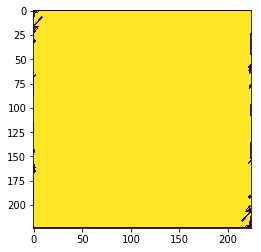

In [25]:
oLabel = DSM_one_pass(oDSM,oDSMs,scanlines_direction,iExt,oLabel,dThrHeightDiff,dThrSlope)
# pour faire le second passage avec les direction allant d'en bas à droite vers en haut à gauche, 
# on fait un rotation de 180° du DSM et du DSM smoothed ensuite on ajoute à la première passe le oLabel que l'on
# transformera en le faisant tourner de 180°
oDSM = np.rot90(np.rot90(oDSM))
oDSMs = np.rot90(np.rot90(oDSMs))
oLabel = oLabel + np.rot90(np.rot90(DSM_one_pass(oDSM,oDSMs,scanlines_direction,iExt,oLabel,dThrHeightDiff,dThrSlope)))
print(oLabel)
filtre = np.zeros(oLabel.shape)
filtre = oLabel>=4
plt.imshow(filtre)